# Introduction

This notebook contains my implementation of the [Generative Adversarial Nets](https://arxiv.org/abs/1406.2661) paper. I start off by going through the theory and then implementing the ideas of the paper, as best as I can within my resource constrained environment.

# Theory

**Contributions**

The main contributions of this paper are as follows:
1.   The introduction of a new generative modelling framework - GANs.
2.   Generative modelling through only back-propagation, bypassing the need for Markov Chains and Approximate Inference.



**Significance**

Up until the point this paper was introduced, Deep Generative Models were few and far between, with them also being very difficult to train. For instance, most generative models required approximate inference of intractable computations and training through the use of markov chains. These are highly undesirable characteristics, which produced lackluster results.

As such, the authors of this paper introduce the GAN framework which allows the training of a generative model through only backpropagation and also bypassing the need for an intractable inference computation.

**Synxtax**

*   z is a latent variable which is sampled from a fixed prior distribution $p_z(z)$.
*   G is the generative model with trainable parameters $\theta \in \mathbb{R}^{n}$.
*   D is the disciminative model with trainable parameters $\phi \in \mathbb{R}^{m}$.
*   $p_{data}$ is the data distribution.
*   $p_g$ is the generative distribution.
*   $p_{g \cup data} = \{x | x \sim p_{data} \text{or} x \sim p_{g} \}$

**Main ideas**

The GAN framework is relatively simple to understand. We have two models: a generative model G, and a disciminative model D. The generative model, G, maps from a fixed prior latent distribution to the generative distribution with the idea that through training, this generative distribution converges to the data distribution. Training occurs via an adversarial process, with the disciminative model D detecting whether the sampled data is from $p_{data}$ rather than $p_g$, by outputting a probability.

**In Equations**

The Generative model maps from a fixed prior latent distribution to the generative distribution:
$$
  G: p_{z} × \mathbb{R}^{n} → p_{g}
$$
$$
  G: z × \theta \mapsto x
$$
The main idea is that through training, $p_g$ converges to $p_{data}$.

The Generative model tries to fool the Disciminative model into thinking that data sampled from $p_g$ is from $p_{data}$. The Disciminative model thus outputs the probability that the sample is from $p_{data}$ rather than $p_g$:
$$
  D: p_{g \cup data} \times \mathbb{R}^{m} → [0, 1]
$$
$$
  D: x \times \phi \mapsto p
$$

The authors of this paper formulate this as a 2-player mini-max game with the value function V(G, D):
$$
min_{G} max_{D} V(G, D) = \mathbb{E}_{x \sim p_{data}(x)}[log(D(x))] + \mathbb{E}_{z \sim p_{z}(z)}[log(1 - D(G(z)))]
$$
Simply, we train D to maximise the probability of samples drawn from $p_{data}$ and minimise the probability of samples drawn from $p_{g}$ (or $p_z$ and then passed through G).

**Training**

Training isn't so simple, as optimising D to completion is computationally prohibitive and will result in overfitting on a finite dataset. Instead, train D for k steps then train G for 1 step.

Additionally, training G to maximise $log(D(G(z)))$ is much easier, and the author's state that the original objective saturates, but using this new objective results in the same fixed point but results in much stronger gradients early in training.

The training algorithm introduced by the paper is shown below:

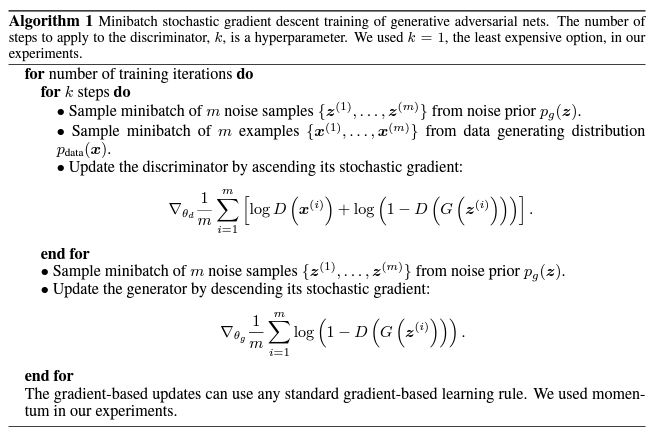

**Convergence**

In this section, we show that G converges to the optimal solution, resulting in $p_G$ converging $p_{data}$.

**Proposition 1.** For G fixed, the optimal disciminator D is

$$
D^{*}_{G}(x) = \frac{p_{data}(x)}{p_{data}(x) + p_{g}(x)}
$$

This makes sense, as the optimal D should return a probability based on the ratios of the probabilities of $p_{data}$ and $p_{g}$. Thus, this results in the value function reducing to:

$$
C(G) = max_{D} V(G, D)
$$
$$
= \mathbb{E}_{x \sim p_{data}}[log(D^{*}_{G}(x))] + \mathbb{E}_{z \sim p_{z}}[log(1 - D^{*}_{G}(G(z)))]
$$
$$
= \mathbb{E}_{x \sim p_{data}}[log(D^{*}_{G}(x))] + \mathbb{E}_{x \sim p_{g}}[log(1 - D^{*}_{G}(x))]
$$
$$
= \mathbb{E}_{x \sim p_{data}}[log(\frac{p_{data}(x)}{p_{data}(x) + p_{g}(x)})] + \mathbb{E}_{x \sim p_{g}}[log(\frac{p_{g}(x)}{p_{data}(x) + p_{g}(x)})]
$$

**Theorem 1.** The global minimum of the virtual training critertion C(G) is achieved iff $p_g = p_{data}$. At that point, C(G) achieves the value $-\log4$.

*proof.* This is a relative simple proof with a lot of consequences.

Firstly, if $p_g = p_{data}$, then $D^{*}_G(x) = \frac{1}{2}$. Hence, $C(G) = -\log4$ at this point, namely the minima. To prove this is the global minima, we first take away and add the minima as shown below:

$$
C(G) = C(G) + \log4 - \log4 = C(G) + \log2 + \log2 - \log4
$$

$$
= \mathbb{E}_{x \sim p_{data}}[log(\frac{p_{data}(x)}{p_{data}(x) + p_{g}(x)}) + \mathbb{E}_{x \sim p_{g}}[log(\frac{p_{g}(x)}{p_{data}(x) + p_{g}(x)})]
+ \log2 + \log2 - \log4
$$

$$
= \mathbb{E}_{x \sim p_{data}}[log(\frac{2p_{data}(x)}{p_{data}(x) + p_{g}(x)}) + \mathbb{E}_{x \sim p_{g}}[log(\frac{2p_{g}(x)}{p_{data}(x) + p_{g}(x)})]
- \log4
$$

Which can be written as the KL Divergence as follows:

$$
= KL(p_{data} || \frac{p_{data} + p_{g}}{2}) + KL(p_{g} || \frac{p_{data} + p_{g}}{2}) - \log4
$$

This KL divergence can be written as the Jensen-Shannon Divergence to give:

$$
C(G) = -\log4 + 2 \cdot JSD(p_{data} || p_{g}) ≥ -\log4
$$

Where the final inequality is due to the Jensen-Shannon Divergence being non-negative. Thus, we have shown that if $p_{g}$ converges to $p_{data}$ in Jensen-Shannon, then, $-\log4$ is the minima of the value function $C(G)$. Thus, the unique optimal solution for $p_{g}$ is $p_{data}$.

The Author's of the paper then prove that if the disciminator is allowed to reach its optimal solution given G, $D^{*}_{G}$, then the JS-divergence is minimised and the value function $C(G)$ is minimised towards minima $-\log4$, resulting in $p_{g}$ converging to $p_{data}$.

**Key Points**

*   Given enough capacity in G and D, training D to the optimal solution $D^{*}_{G}$ and then optimising G will result in $p_g$ converging toward $p_{data}$.
*   We do not optimise $p_g$, instead, we Optimise G - meaning we don't have to perform inference and all training occurs solely through back-propagation.



# Implementation

## Imports and Installations

In [ ]:
!pip install clu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.9/100.9 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 48.7 MB/s eta 0:00:00
  Created wheel for ml-collections: filename=ml_collections-0.1.1-py3-none-any.whl size=94505 sha256=aaac01df7b364a4ece618cd6c3d4fcaefedf7fc24251ef9dc3730b955c512ddb
  Stored in directory: /root/.cache/pip/wheels/7b/89/c9/a9b87790789e94aadcfc393c283e3ecd5ab916aed0a31be8fe
Successfully built ml-collections
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido,

In [ ]:
# Don't preallocate VRAM
%env XLA_PYTHON_CLIENT_PREALLOCATE=false

# data loading
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np

# deep learning
import jax
import jax.numpy as jnp
import flax
import flax.linen as nn
import optax
from clu import metrics
from functools import partial

# plotting
import matplotlib.pyplot as plt

# timing
from time import perf_counter

env: XLA_PYTHON_CLIENT_PREALLOCATE=false


## Hyperparameters

In [ ]:
tf.random.set_seed(42)

k = 1 # Training ratio of Disciminator to Generator, k:1
batch_size = 64
latent_dim = 100 # Dimension of the latent space
EPOCHS = 50 # Number of epochs to train for
lr = 2e-4

weight_init = nn.initializers.normal(0.02)
# Latent distribution is U(-1,1)
latent_dist = lambda key, shape, dtype: jax.random.uniform(key, shape, dtype, minval=-1, maxval=1)

# Data Loading

In [ ]:
def get_mnist(batch_size, return_sample=True):
  def neg1_1_normalise(data, label):
    return (tf.cast(data, dtype=tf.float32) - 127.5) / 127.5, label

  MNIST = tfds.load("mnist", as_supervised=True)
  train_ds, test_ds = MNIST["train"], MNIST["test"]

  train_ds = train_ds.map(neg1_1_normalise, num_parallel_calls=tf.data.AUTOTUNE).cache().shuffle(1000).batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
  test_ds = test_ds.map(neg1_1_normalise, num_parallel_calls=tf.data.AUTOTUNE).cache().batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

  if return_sample == True:
    for sample_data, sample_label in train_ds.as_numpy_iterator():
      print("Sample data:", sample_data.shape)
      print("Sample label:", sample_label.shape)
      plt.figure(figsize=(2,2))
      plt.imshow((sample_data[0]+1) / 2)
      return train_ds, test_ds, sample_data, sample_label
  return train_ds, test_ds

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.
Sample data: (64, 28, 28, 1)
Sample label: (64,)
tf.Tensor(937, shape=(), dtype=int64)


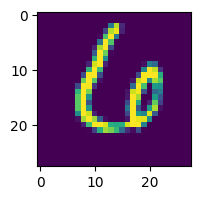

In [ ]:
train_ds, test_ds, sample_data, sample_label = get_mnist(batch_size)
print(train_ds.cardinality())

## TrainState and Metrics

In [ ]:
from flax.training import train_state

@flax.struct.dataclass
class Metrics(metrics.Collection):
  loss: metrics.Average.from_output("loss")

class TrainState(train_state.TrainState):
  rng: jax.Array
  metrics: Metrics = Metrics.empty()

## Create and Initialise State

In [ ]:
def create_state_and_initialise_model(G, D, sample_data, latent_dim, random_key):
  keys = jax.random.split(random_key, 4)
  sample_latent = jnp.zeros((batch_size, latent_dim))

  g = G()
  d = D()

  g_vars = g.init(keys[0], sample_latent, train=False)
  d_vars = d.init(keys[1], sample_data, train=False)

  print(g.tabulate(keys[0], sample_latent, train=False))
  print(d.tabulate(keys[1], sample_data, train=False))

  g_state = TrainState.create(
      apply_fn=g.apply,
      params=g_vars["params"],
      tx=optax.adam(lr, b1=0.5),    # Note the use of the Adam optimiser with a momentum of 0.5
      rng=keys[2]
  )

  d_state = TrainState.create(
      apply_fn=d.apply,
      params=d_vars["params"],
      tx=optax.adam(lr, b1=0.5),
      rng=keys[3]
  )

  return g_state, d_state, g, d

## Model Definition

In [ ]:
class G(nn.Module):
  @nn.compact
  def __call__(self, z, train):
     z = nn.Dense(500, kernel_init=weight_init)(z)
     z = nn.relu(z)
     z = nn.Dropout(0.2, deterministic=not train)(z)
     z = nn.Dense(1000, kernel_init=weight_init)(z)
     z = nn.relu(z)
     z = nn.Dense(784, kernel_init=weight_init)(z)
     z = nn.tanh(z)
     z = z.reshape([z.shape[0], 28, 28, 1])
     return z

class D(nn.Module):
  @nn.compact
  def __call__(self, x, train):
    x = x.reshape([x.shape[0], -1])
    x = nn.Dense(256, kernel_init=weight_init)(x)
    x = nn.relu(x)      # Note the use of relu. The original paper used maxout in the disciminator.
    x = nn.Dropout(0.2, deterministic=not train)(x)
    x = nn.Dense(128, kernel_init=weight_init)(x)
    x = nn.relu(x)
    x = nn.Dropout(0.2, deterministic=not train)(x)
    x = nn.Dense(1, kernel_init=weight_init)(x)
    return x

## Disciminator Train Step

In [ ]:
@jax.jit
def d_train_step(g_state, d_state, batch):
  data, label = batch
  ones = jnp.ones((batch_size, 1))
  zeros = jnp.zeros((batch_size, 1))
  latent_key, d_dropout_key_1, d_dropout_key_2 = jax.random.split(jax.random.fold_in(d_state.rng, d_state.step), 3)
  z = latent_dist(latent_key, (batch_size, latent_dim), data.dtype)
  def loss(params):
    tru_logits = d_state.apply_fn({"params": params}, data, train=True, rngs={"dropout": d_dropout_key_1})
    tru_loss = optax.sigmoid_binary_cross_entropy(logits=tru_logits, labels=ones)

    gen_x = g_state.apply_fn({"params": g_state.params}, z, train=False)
    gen_logits = d_state.apply_fn({"params": params}, gen_x, train=True, rngs={"dropout": d_dropout_key_2})
    gen_loss = optax.sigmoid_binary_cross_entropy(logits=gen_logits, labels=zeros)

    return (tru_loss + gen_loss).mean() / 2

  grad_fn = jax.value_and_grad(loss)

  d_loss, grads = grad_fn(d_state.params)

  metrics = d_state.metrics.single_from_model_output(loss=d_loss)
  metrics = d_state.metrics.merge(metrics)

  d_state = d_state.apply_gradients(grads=grads, metrics=metrics)
  return d_state

## Generator Train Step

In [ ]:
@jax.jit
def g_train_step(g_state, d_state, batch):
  data, label = batch
  ones = jnp.ones((batch_size, 1))
  latent_key, g_dropout_key = jax.random.split(jax.random.fold_in(g_state.rng, g_state.step), 2)
  z = latent_dist(latent_key, (batch_size, latent_dim), data.dtype)
  def loss(params):
    gen_x = g_state.apply_fn({"params": params}, z, train=True, rngs={"dropout": g_dropout_key})
    logits = d_state.apply_fn({"params": d_state.params}, gen_x, train=False)
    loss = optax.sigmoid_binary_cross_entropy(logits=logits, labels=ones).mean()
    return loss

  grad_fn = jax.value_and_grad(loss)

  g_loss, grads = grad_fn(g_state.params)

  metrics = g_state.metrics.single_from_model_output(loss=g_loss)
  metrics = g_state.metrics.merge(metrics)

  g_state = g_state.apply_gradients(grads=grads, metrics=metrics)
  return g_state

## Helpers

In [ ]:
def update_metrics(g_state, d_state, metrics_history):
  for k,v in g_state.metrics.compute().items():
    metrics_history[f"g_train_{k}"].append(v)
  for k,v in d_state.metrics.compute().items():
    metrics_history[f"d_train_{k}"].append(v)
  d_state = d_state.replace(metrics=d_state.metrics.empty())
  g_state = g_state.replace(metrics=g_state.metrics.empty())
  return g_state, d_state, metrics_history

In [ ]:
def neg1_1_to_0_1(image):
  return (image + 1.0) / 2.0

def plot_samples(n=None, z=None, ):
  if z == None:
    z = latent_dist(jax.random.PRNGKey(453453), shape=(10, latent_dim), dtype=jnp.float32)
  n = len(z)

  gen_x = g_state.apply_fn({"params": g_state.params}, z, train=False)
  gen_x = neg1_1_to_0_1(gen_x)

  fig, axs = plt.subplots(nrows=1, ncols=n, figsize=(15, n*15))
  for i in range(n):
    axs[i].imshow(gen_x[i], interpolation="nearest")
  plt.axis("off")
  plt.tight_layout()
  plt.show()

## Training

In [ ]:
g_state, d_state, g, d = create_state_and_initialise_model(G, D, sample_data, latent_dim, jax.random.PRNGKey(0))


                                          G Summary                                          
┏━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path      ┃ module  ┃ inputs            ┃ outputs             ┃ params                    ┃
┡━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           │ G       │ - float32[64,100] │ float32[64,28,28,1] │                           │
│           │         │ - train: False    │                     │                           │
├───────────┼─────────┼───────────────────┼─────────────────────┼───────────────────────────┤
│ Dense_0   │ Dense   │ float32[64,100]   │ float32[64,500]     │ bias: float32[500]        │
│           │         │                   │                     │ kernel: float32[100,500]  │
│           │         │                   │                     │                           │
│           │         │                   │                

In [ ]:
metrics_history = {
    "g_train_loss" : [],
    "d_train_loss" : [],
}

Epoch 1|d step 469, g step 468| Time: 10.305310617999993s| g_loss: 0.9874724745750427| d_loss: 0.4577794671058655.


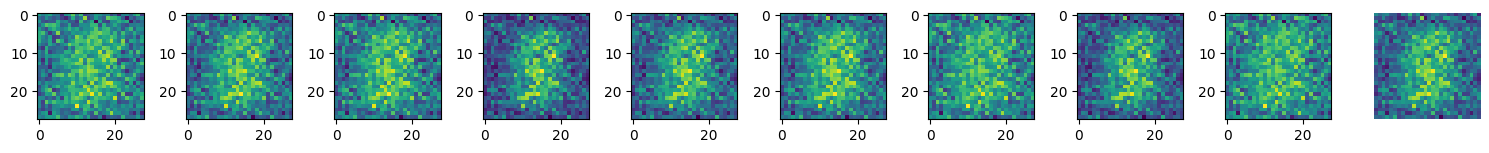

Epoch 2|d step 937, g step 937| Time: 1.2366051639999966s| g_loss: 1.8519988059997559| d_loss: 0.26541656255722046.


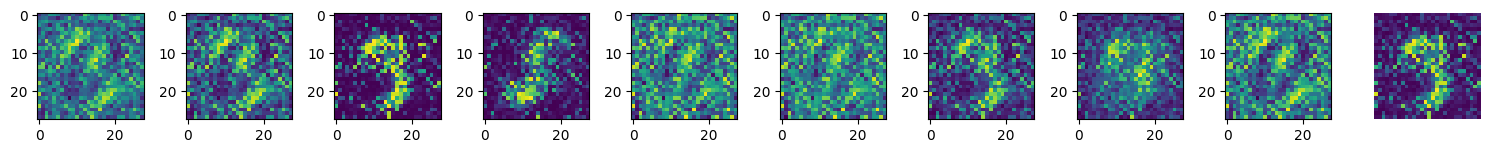

Epoch 3|d step 1406, g step 1405| Time: 1.2642190030000222s| g_loss: 1.9858686923980713| d_loss: 0.33422255516052246.


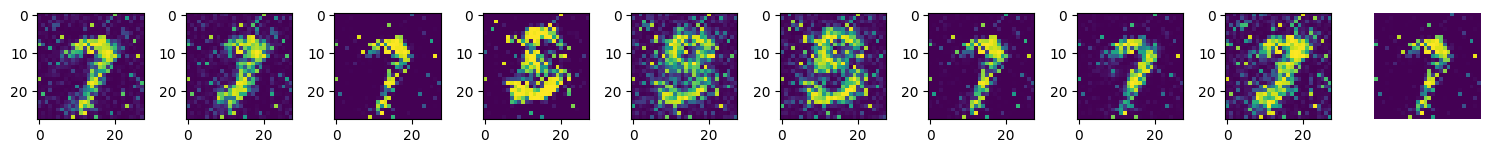

Epoch 4|d step 1874, g step 1874| Time: 1.2633594389999985s| g_loss: 2.4442851543426514| d_loss: 0.2960488200187683.


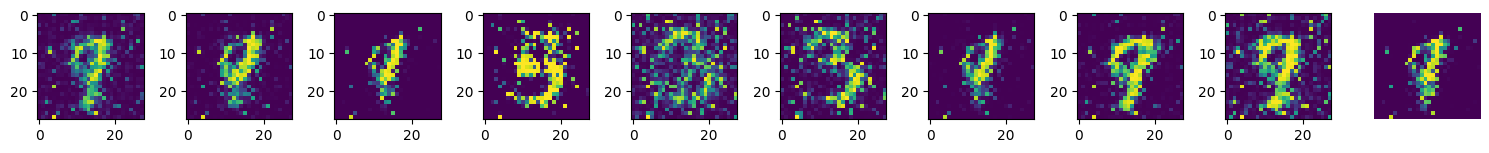

Epoch 5|d step 2343, g step 2342| Time: 2.5509154220000028s| g_loss: 1.981134057044983| d_loss: 0.347019761800766.


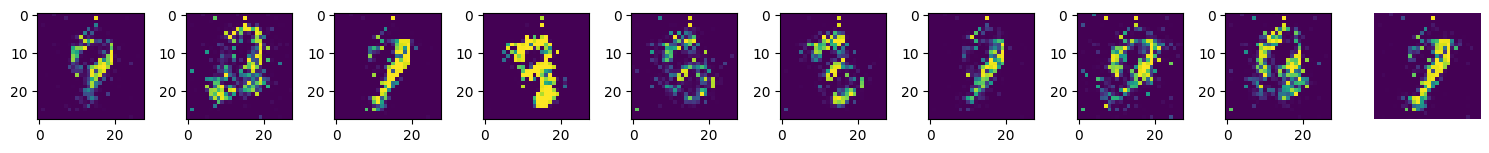

Epoch 6|d step 2811, g step 2811| Time: 1.2352440880000017s| g_loss: 1.9928234815597534| d_loss: 0.3408689796924591.


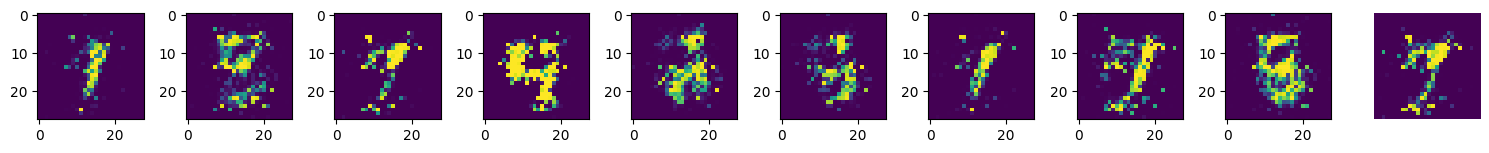

Epoch 7|d step 3280, g step 3279| Time: 1.2243038320000323s| g_loss: 2.017115831375122| d_loss: 0.34172263741493225.


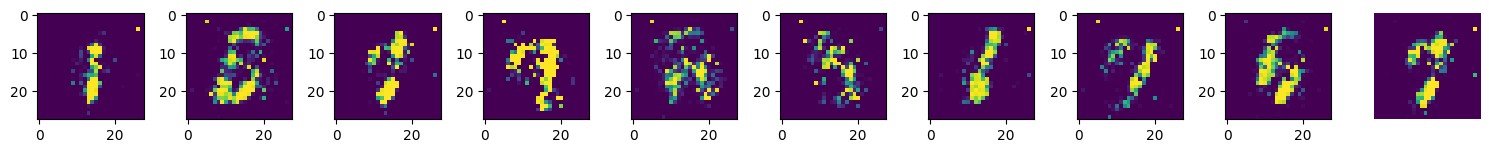

Epoch 8|d step 3748, g step 3748| Time: 1.2106537850000336s| g_loss: 1.8596417903900146| d_loss: 0.3785794973373413.


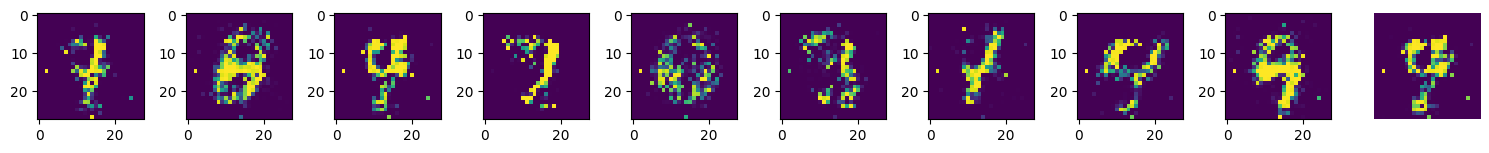

Epoch 9|d step 4217, g step 4216| Time: 1.6272879680000187s| g_loss: 1.7937432527542114| d_loss: 0.39109453558921814.


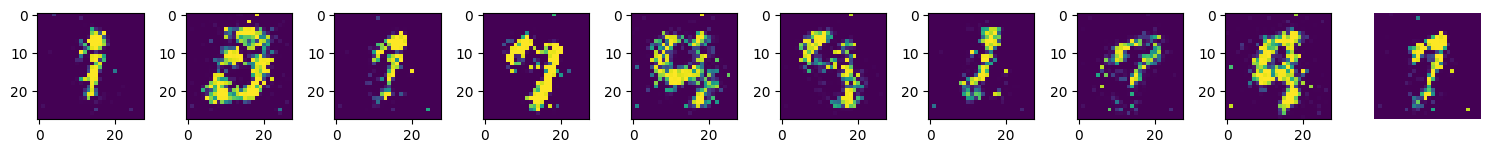

Epoch 10|d step 4685, g step 4685| Time: 2.5465981730000067s| g_loss: 1.6065738201141357| d_loss: 0.41531360149383545.


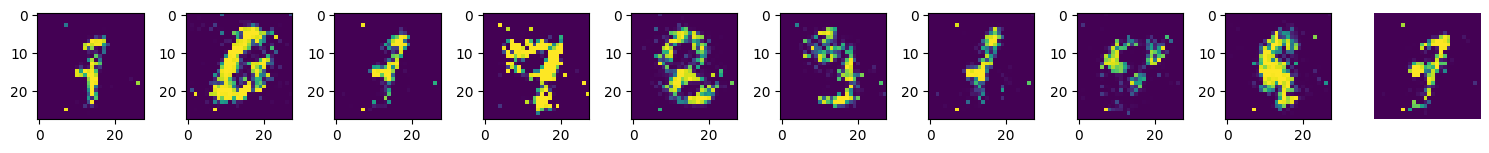

Epoch 11|d step 5154, g step 5153| Time: 1.1901479119999863s| g_loss: 1.6017770767211914| d_loss: 0.42549675703048706.


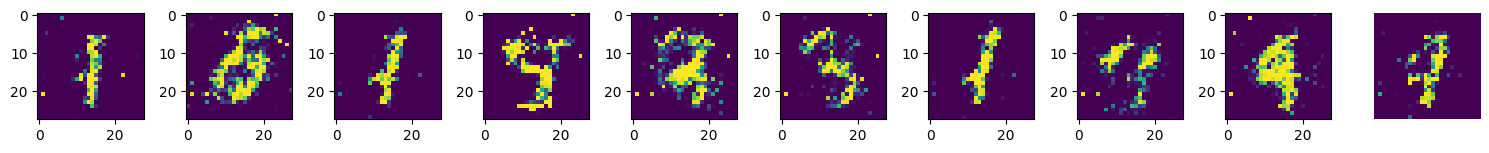

Epoch 12|d step 5622, g step 5622| Time: 1.4180137560000503s| g_loss: 1.531308889389038| d_loss: 0.43714362382888794.


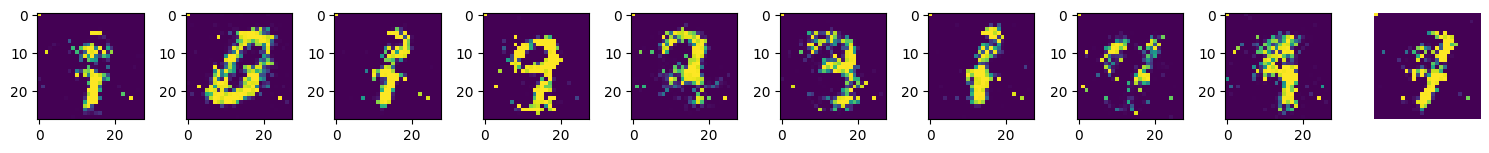

Epoch 13|d step 6091, g step 6090| Time: 1.6290966200000412s| g_loss: 1.5212172269821167| d_loss: 0.42691779136657715.


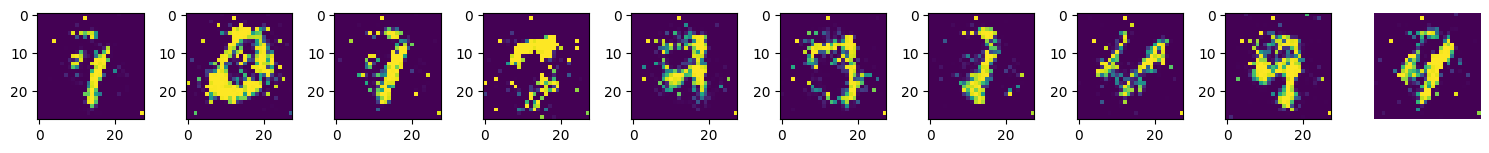

Epoch 14|d step 6559, g step 6559| Time: 3.876445514000011s| g_loss: 1.4640651941299438| d_loss: 0.45728176832199097.


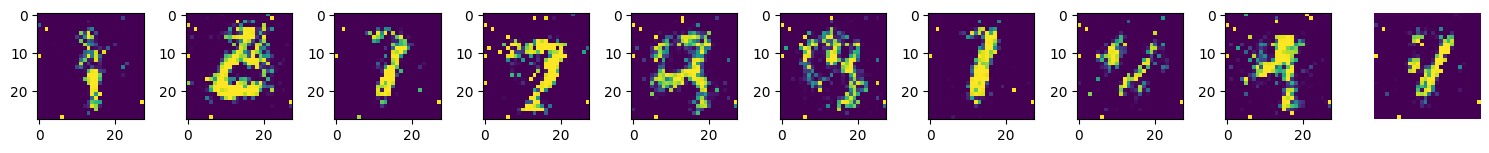

Epoch 15|d step 7028, g step 7027| Time: 1.5506544680000047s| g_loss: 1.424846887588501| d_loss: 0.47143110632896423.


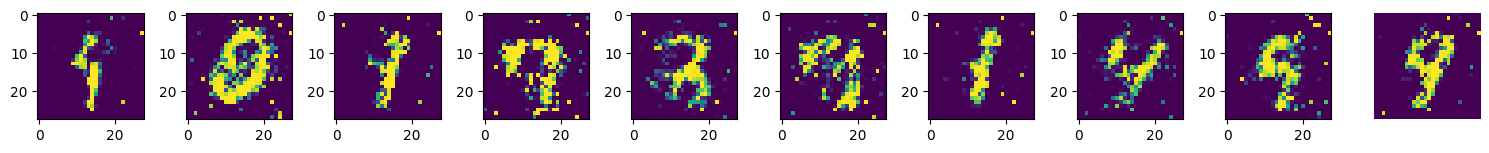

Epoch 16|d step 7496, g step 7496| Time: 1.5923045139999772s| g_loss: 1.337782859802246| d_loss: 0.5073952674865723.


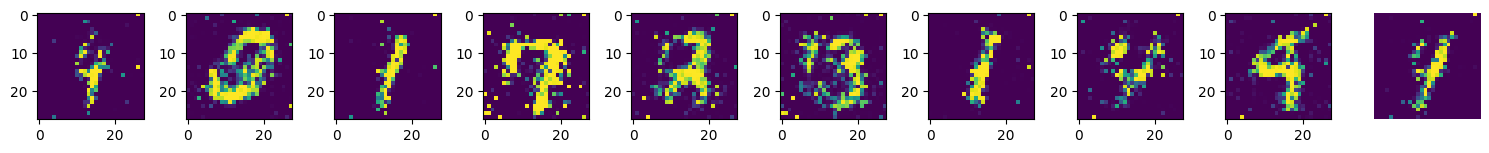

Epoch 17|d step 7965, g step 7964| Time: 2.546327058999964s| g_loss: 1.2476707696914673| d_loss: 0.5152988433837891.


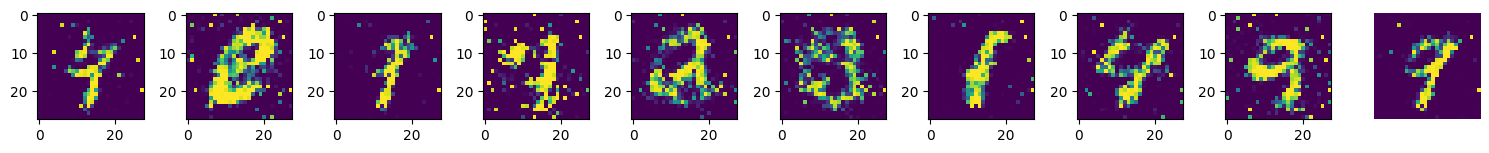

Epoch 18|d step 8433, g step 8433| Time: 1.7280317159999754s| g_loss: 1.1972020864486694| d_loss: 0.5432294607162476.


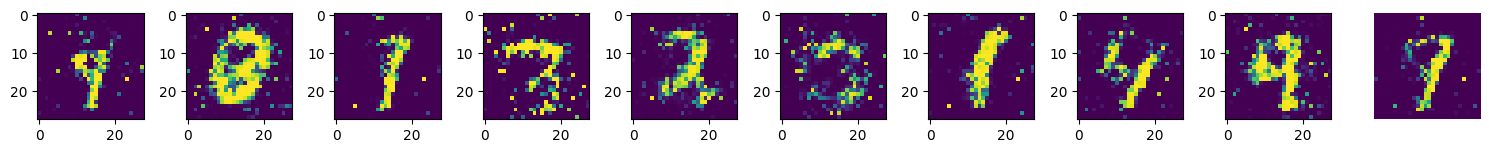

Epoch 19|d step 8902, g step 8901| Time: 1.6502887369999826s| g_loss: 1.1065673828125| d_loss: 0.5438292622566223.


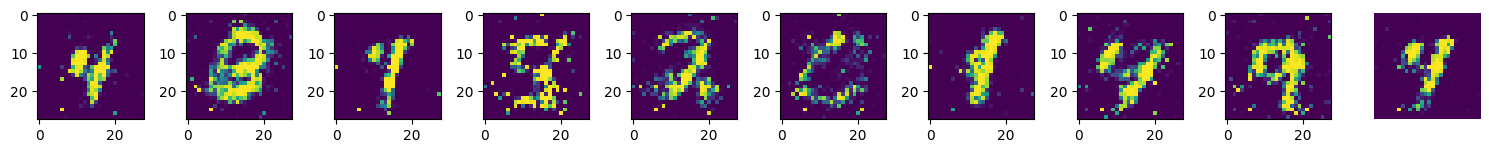

Epoch 20|d step 9370, g step 9370| Time: 1.463970388000007s| g_loss: 1.1133748292922974| d_loss: 0.5507861971855164.


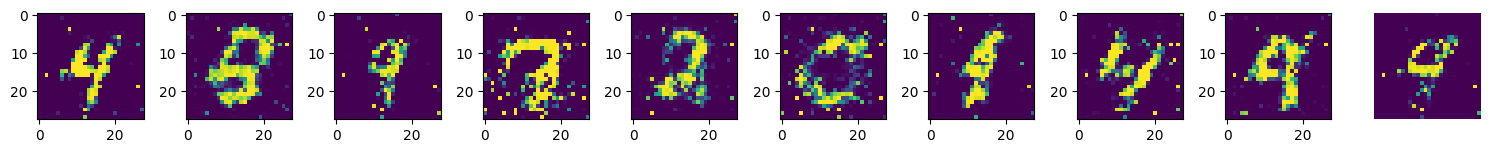

Epoch 21|d step 9839, g step 9838| Time: 1.2662532940000233s| g_loss: 1.1257188320159912| d_loss: 0.5518302321434021.


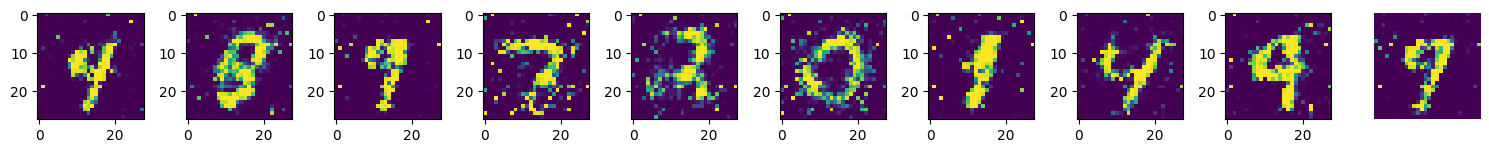

Epoch 22|d step 10307, g step 10307| Time: 2.3301510349999717s| g_loss: 1.0813804864883423| d_loss: 0.5652662515640259.


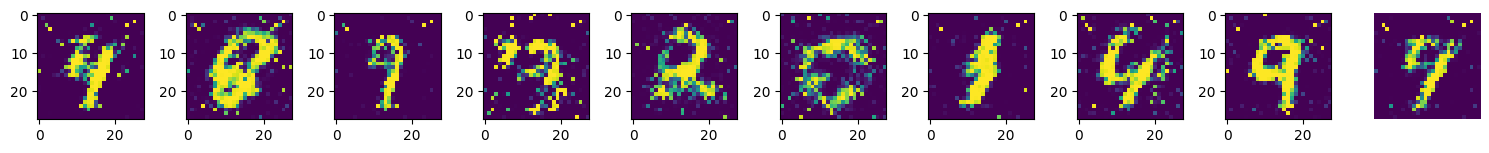

Epoch 23|d step 10776, g step 10775| Time: 2.5457198770000105s| g_loss: 1.0732461214065552| d_loss: 0.5688932538032532.


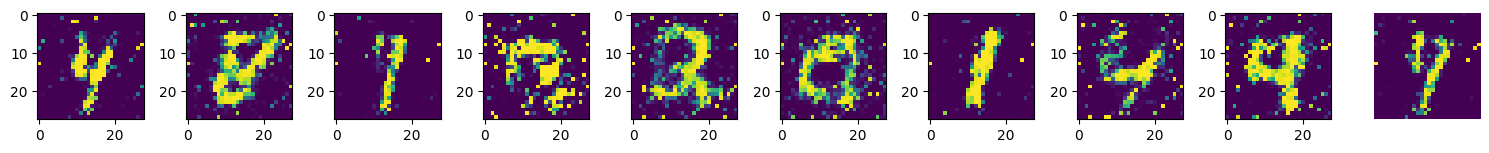

Epoch 24|d step 11244, g step 11244| Time: 1.57654414000001s| g_loss: 1.0505543947219849| d_loss: 0.5751173496246338.


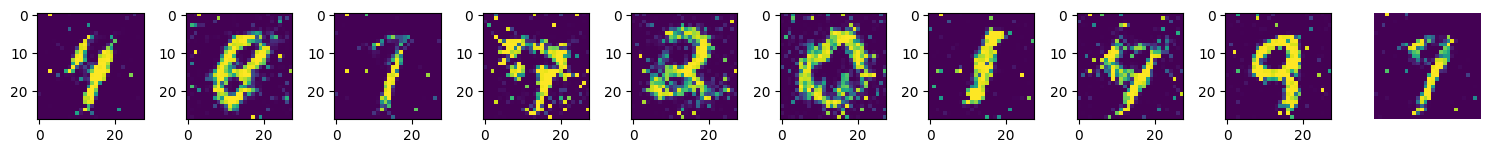

Epoch 25|d step 11713, g step 11712| Time: 2.5556667660000016s| g_loss: 1.0361045598983765| d_loss: 0.5805186033248901.


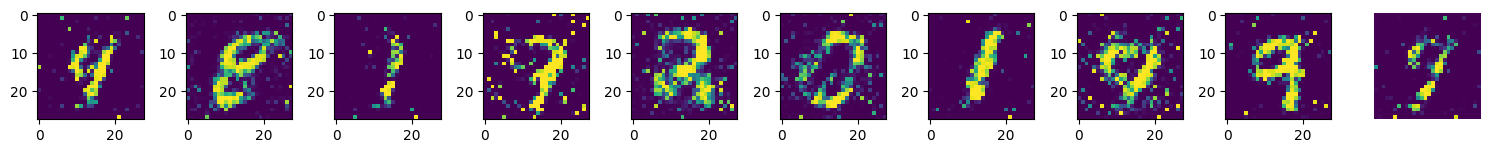

Epoch 26|d step 12181, g step 12181| Time: 1.4376815260000058s| g_loss: 1.0345491170883179| d_loss: 0.585838258266449.


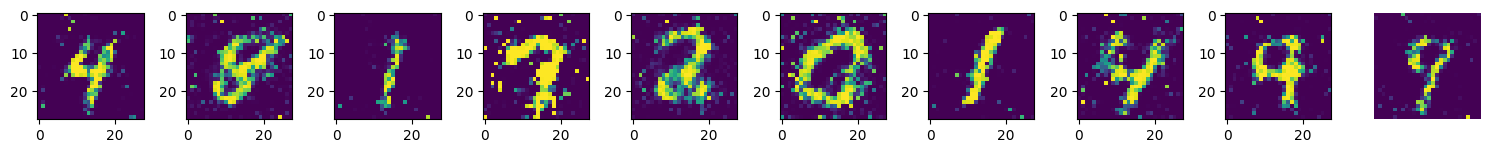

Epoch 27|d step 12650, g step 12649| Time: 1.5446622619999744s| g_loss: 1.0194480419158936| d_loss: 0.5925135612487793.


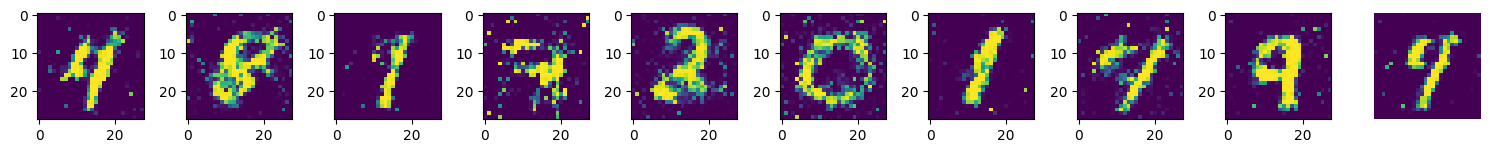

Epoch 28|d step 13118, g step 13118| Time: 2.5463034990000324s| g_loss: 1.0165811777114868| d_loss: 0.5966649055480957.


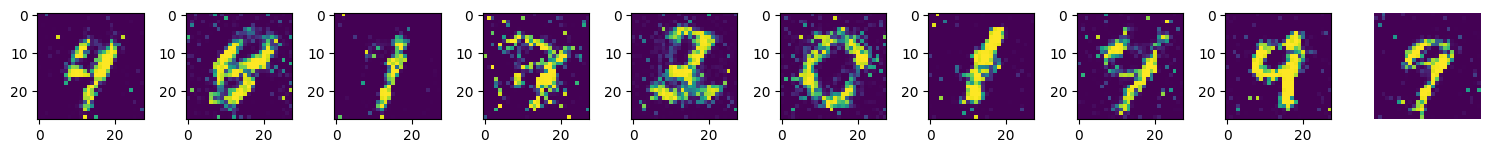

Epoch 29|d step 13587, g step 13586| Time: 2.5513970279999967s| g_loss: 1.0064033269882202| d_loss: 0.5978820323944092.


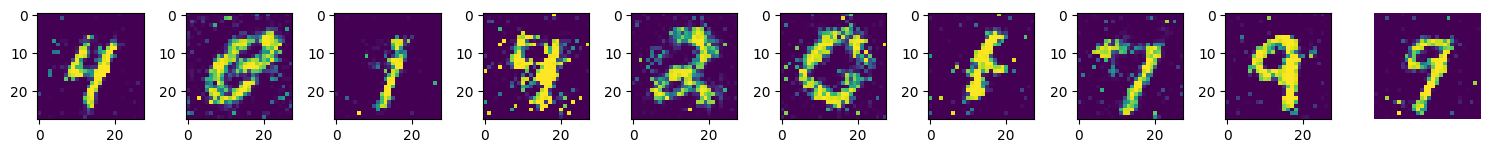

Epoch 30|d step 14055, g step 14055| Time: 1.4809621009999887s| g_loss: 1.0112861394882202| d_loss: 0.6024736762046814.


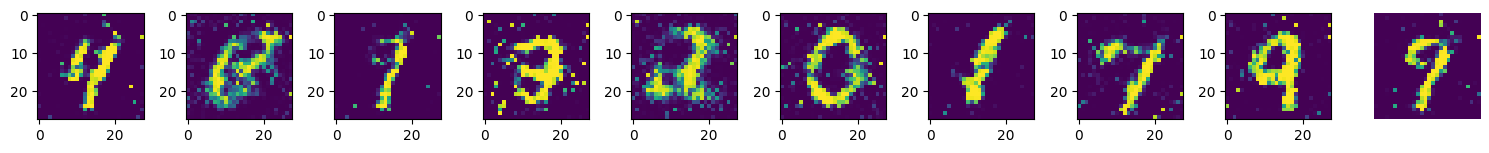

Epoch 31|d step 14524, g step 14523| Time: 1.2663870270000075s| g_loss: 1.008113145828247| d_loss: 0.6053808331489563.


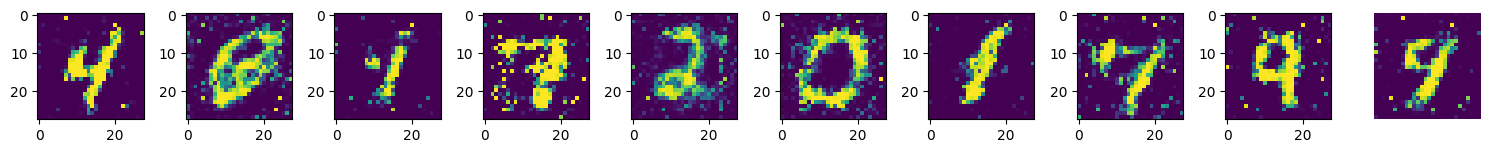

Epoch 32|d step 14992, g step 14992| Time: 1.1840279550000332s| g_loss: 1.0072228908538818| d_loss: 0.6120254993438721.


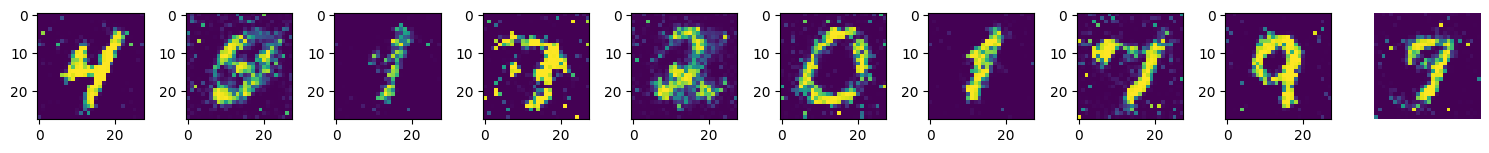

Epoch 33|d step 15461, g step 15460| Time: 2.546580795000011s| g_loss: 1.021146297454834| d_loss: 0.6074151992797852.


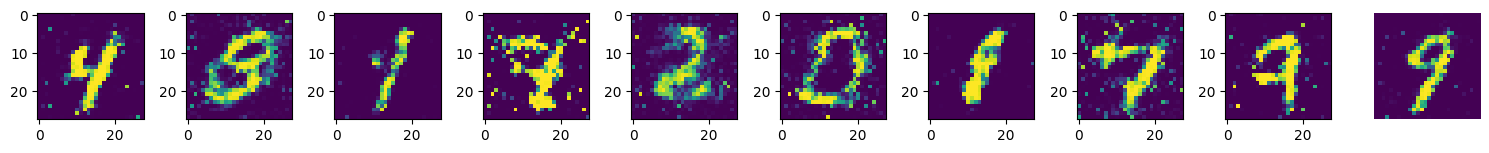

Epoch 34|d step 15929, g step 15929| Time: 1.2063124239999752s| g_loss: 1.0445506572723389| d_loss: 0.6036128997802734.


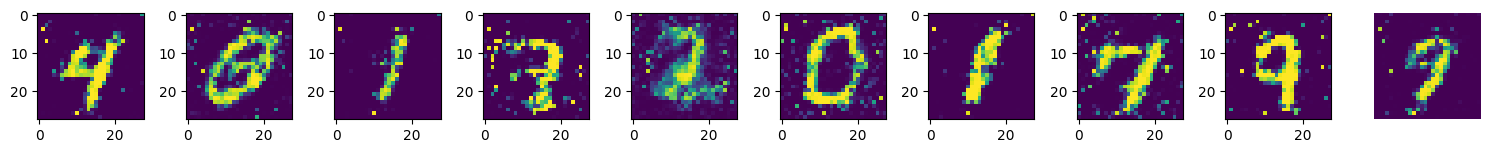

Epoch 35|d step 16398, g step 16397| Time: 2.547691853999993s| g_loss: 1.0601353645324707| d_loss: 0.6068100929260254.


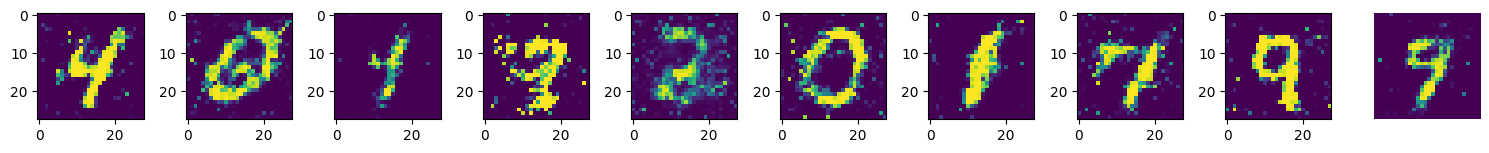

Epoch 36|d step 16866, g step 16866| Time: 1.612308660999986s| g_loss: 1.0565403699874878| d_loss: 0.6044344902038574.


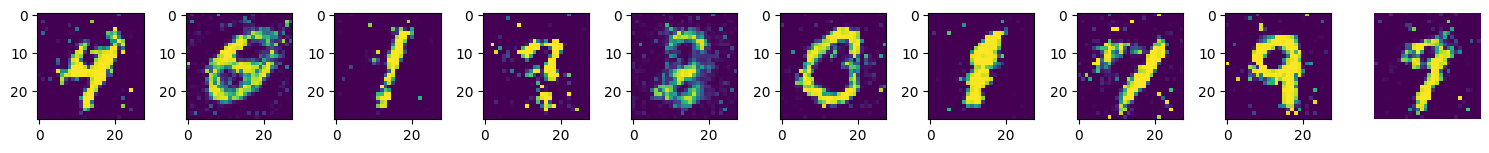

Epoch 37|d step 17335, g step 17334| Time: 2.5652953960000104s| g_loss: 1.0991095304489136| d_loss: 0.6020194888114929.


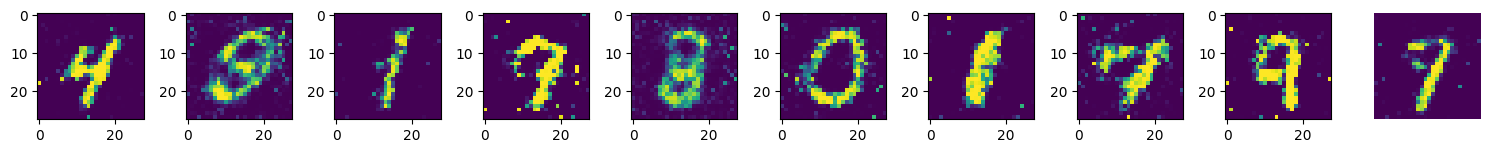

Epoch 38|d step 17803, g step 17803| Time: 1.5858729330000187s| g_loss: 1.0725537538528442| d_loss: 0.6066824197769165.


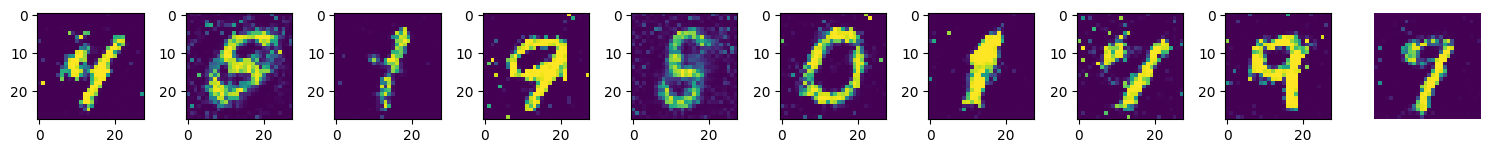

Epoch 39|d step 18272, g step 18271| Time: 1.542883727000003s| g_loss: 1.077274203300476| d_loss: 0.6149082779884338.


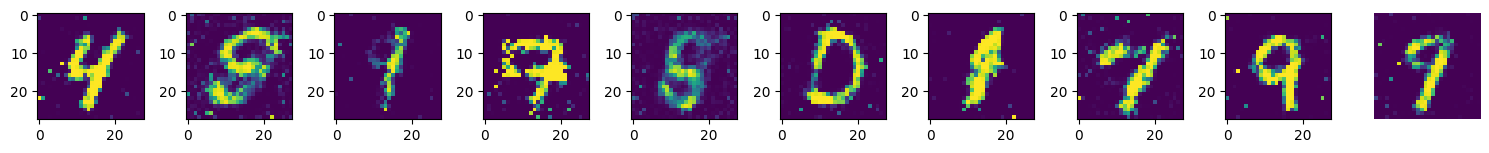

Epoch 40|d step 18740, g step 18740| Time: 1.6359166269999719s| g_loss: 1.0694652795791626| d_loss: 0.6150127053260803.


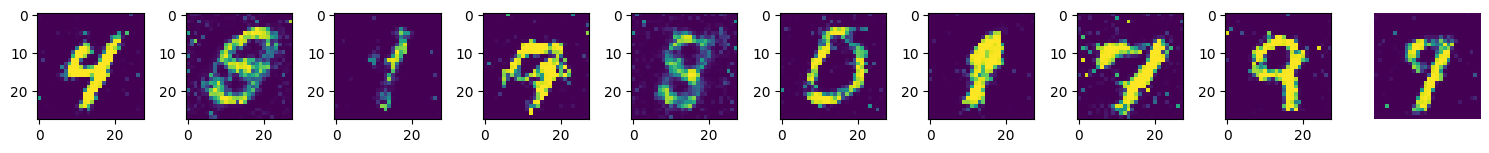

Epoch 41|d step 19209, g step 19208| Time: 2.5561670870000057s| g_loss: 1.0852149724960327| d_loss: 0.6137734055519104.


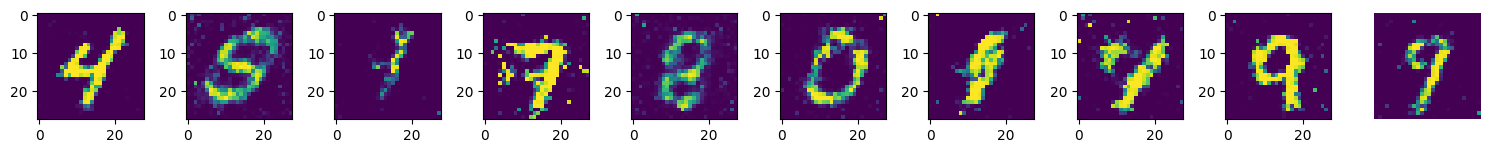

Epoch 42|d step 19677, g step 19677| Time: 1.4819244550000121s| g_loss: 1.0575131177902222| d_loss: 0.6239975094795227.


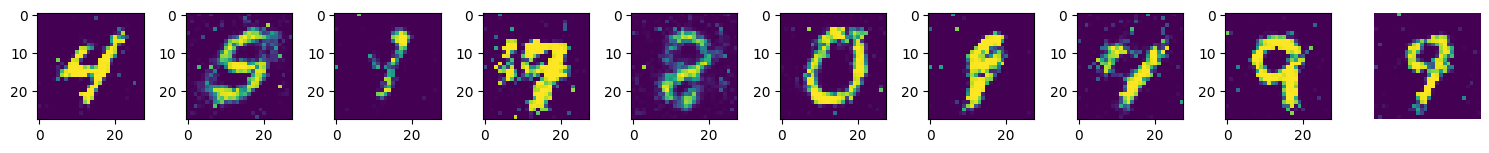

Epoch 43|d step 20146, g step 20145| Time: 1.5584797099999719s| g_loss: 1.0628585815429688| d_loss: 0.6206660270690918.


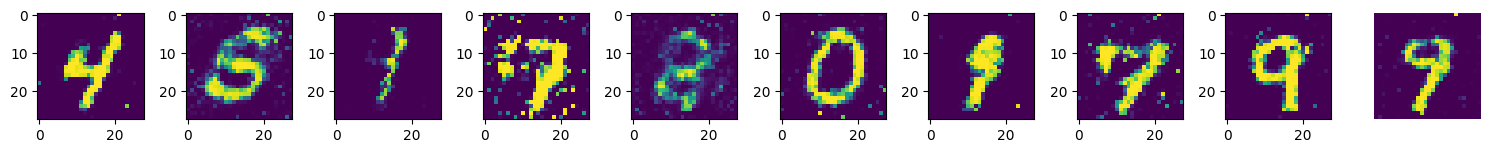

Epoch 44|d step 20614, g step 20614| Time: 2.5474293190000026s| g_loss: 1.0763580799102783| d_loss: 0.6185522079467773.


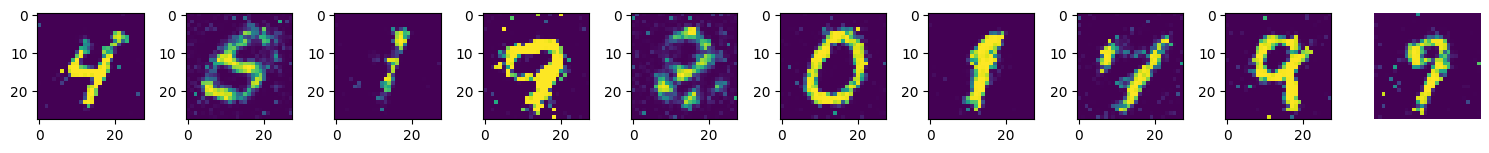

Epoch 45|d step 21083, g step 21082| Time: 2.3300332349999735s| g_loss: 1.1071699857711792| d_loss: 0.6124770641326904.


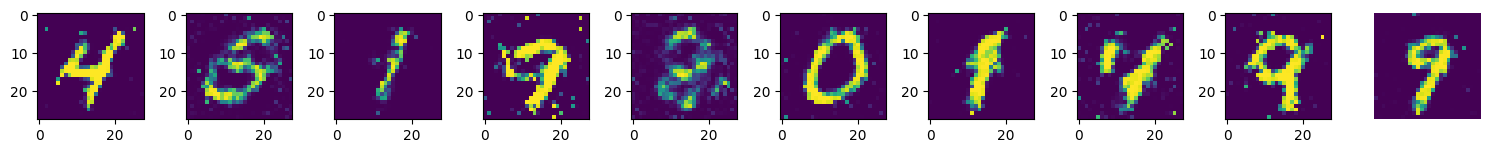

Epoch 46|d step 21551, g step 21551| Time: 2.027211823000016s| g_loss: 1.1274213790893555| d_loss: 0.6177783608436584.


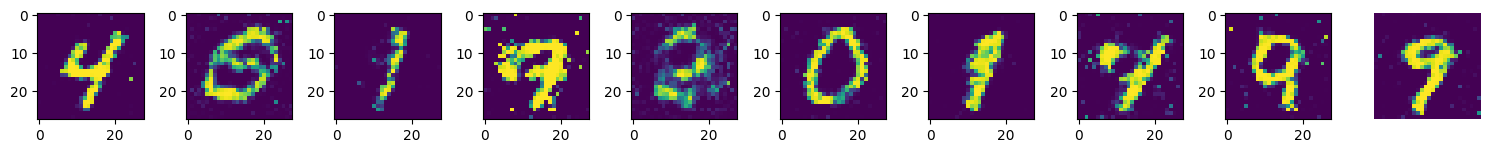

Epoch 47|d step 22020, g step 22019| Time: 1.1985938440000155s| g_loss: 1.1095250844955444| d_loss: 0.6172286868095398.


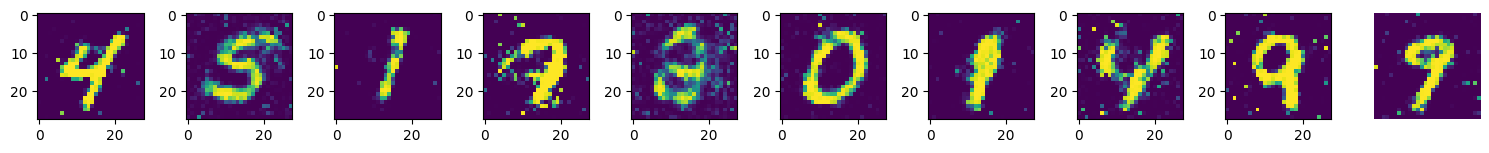

Epoch 48|d step 22488, g step 22488| Time: 1.2663553660000275s| g_loss: 1.1160976886749268| d_loss: 0.6210476160049438.


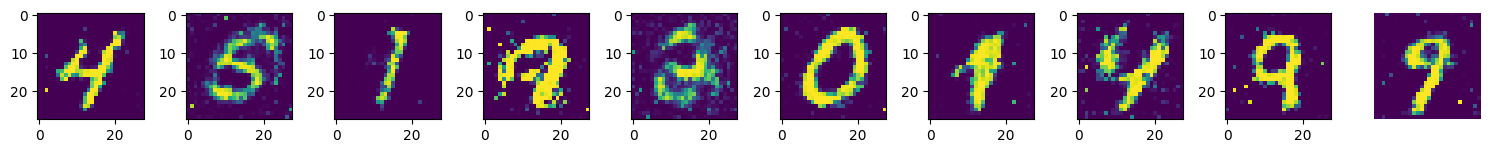

Epoch 49|d step 22957, g step 22956| Time: 1.7427514799999813s| g_loss: 1.1290303468704224| d_loss: 0.6174513697624207.


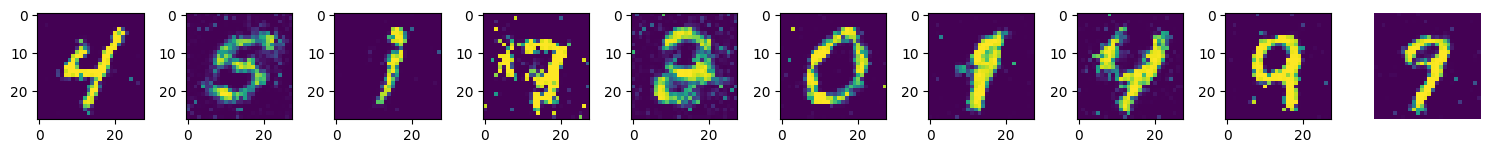

Epoch 50|d step 23425, g step 23425| Time: 1.2740543449999677s| g_loss: 1.1004623174667358| d_loss: 0.6254833340644836.


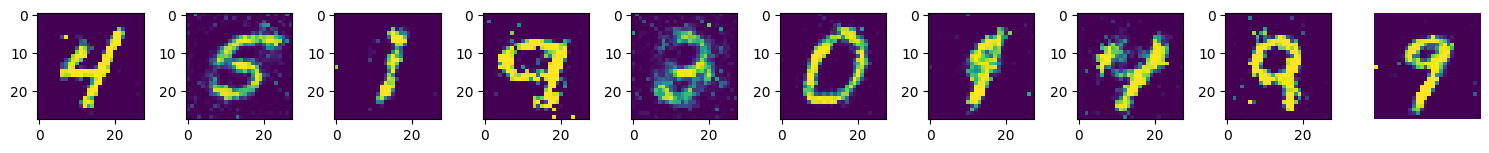

In [ ]:
i = 0
plt.ion()

for epoch in range(1, EPOCHS + 1):
  start = perf_counter()
  for batch in train_ds.as_numpy_iterator():
    if i < k:
      d_state = d_train_step(g_state, d_state, batch)
      i += 1
    else:
      g_state = g_train_step(g_state, d_state, batch)
      i = 0

  g_state, d_state, metrics_history = update_metrics(g_state, d_state, metrics_history)

  g_loss = metrics_history["g_train_loss"][-1]
  d_loss = metrics_history["d_train_loss"][-1]

  print(f"Epoch {epoch}|d step {d_state.step}, g step {g_state.step}| Time: {perf_counter() - start}s| g_loss: {g_loss}| d_loss: {d_loss}.")
  plot_samples()

# Conclusions

GANs are a method of training a Generative Network by bypassing the typical constraints encountered with Maximum Likelihood Estimation Training of Generative Models. But it does have its own issues. Namely, the mode collapse problem, which causes the Generator to collpase in the latent space as to produce only a subset of possible outcomes. Addressing mode collapse requires careful consideration of hyperparameters as well as striking a balance between the generator and disciminator.